## Compute Instantaneous Frequency of Synthetic

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from obspy import UTCDateTime, Stream, Trace
from scipy.signal import welch, periodogram
from numpy import zeros, argmax, arange
from tqdm.notebook import tqdm
from pandas import DataFrame, read_pickle

from andbro__querrySeismoData import __querrySeismoData

## Define Methods

In [2]:
def __makeplot(df):
    
    fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=True)
    
    font = 13 

    ax[0].scatter(df['times'], df['freqs'], s=10, color="r")
    ax[0].plot(df['times'], df['freqs'], "k")    
    
    ax[1].scatter(df['times'], df['hmhw'], s=10, color="r")
    ax[1].plot(df['times'], df['hmhw'], "k") 
    
    ax[2].scatter(df['times'], df['psd_max'], s=10, color="r")
    ax[2].plot(df['times'], df['psd_max'], "k") 
    
    hours = arange(df['times'].min(),df['times'].max()+3600,3600)

    for i in range(3):
        for hrs in hours:
            ax[i].axvline(hrs, 0, 1, zorder=0, alpha=0.4,color='grey')
    
    plt.show();

In [3]:
def __half_width_half_max(data):

    from scipy.signal import find_peaks, peak_widths
    from numpy import argmax
    
    peaks, _ = find_peaks(data)

    half = peak_widths(data, peaks, rel_height=0.5)

    idx = argmax(half[1])
    
    y, xmin, xmax = half[1][idx], half[2][idx], half[3][idx]
#     return xmin, xmax, y

    hh = abs(half[3][idx] - half[2][idx])
    
    return hh

In [4]:
def __multitaper(data, fs, n_windows=4, one_sided=True):

    from spectrum import dpss, pmtm
    from numpy import zeros, arange, linspace, argmax
    
    
    NN = len(data)
    
    ## Option 1
    #[tapers, eigen] = dpss(NN, 2.5, n_windows)
    # spectra, weights, eigenvalues = pmtm(data, e=tapers, v=eigen, show=True)

    ## Option 2
    # res = pmtm(data, NW=2.5, show=False)
    spectra, weights, eigenvalues = pmtm(data, NW=2.5, k=n_windows, show=False)

    ## average spectra
    estimate = zeros(len(spectra[0]))
    for m in range(n_windows):
        estimate += (abs(spectra[m])**2)
    estimate /= n_windows
    
    l = len(estimate)
    frequencies = linspace(-0.5*fs, 0.5*fs, l)
    
    if one_sided:
        f_tmp, psd_tmp = frequencies[int(l/2):], estimate[:int(l/2)]
    else:
        f_tmp, psd_tmp = frequencies, estimate
    
    
    f_max = f_tmp[argmax(psd_tmp)]
    p_max = max(psd_tmp)
    h_tmp = __half_width_half_max(psd_tmp)
    
    return f_tmp, f_max, p_max, h_tmp

In [5]:
def __periodogram(st_in, fs):
    
    from scipy.signal.windows import tukey
    from scipy.signal import periodogram
    from numpy import nanmean, argmax
    
    st_cp = st_in.copy()
            
    tukey_win = tukey(len(st_cp[0].data))

    f_tmp, psd_tmp = periodogram(st_cp[0].data, 
                                 fs=fs, 
                                 window=tukey_win, 
                                 nfft=None, 
                                 detrend='constant', 
                                 return_onesided=True, 
                                 scaling='density', 
                                 )

    f_max = f_tmp[argmax(psd_tmp)]
    p_max = max(psd_tmp)
    h_tmp = __half_width_half_max(psd_tmp)
    
    return f_tmp, f_max, p_max, h_tmp

In [6]:
def __periodogram_multitaper(data, fs, n_windows=4):

    from spectrum import dpss, pmtm
    from numpy import zeros, arange, linspace
    from scipy.signal import find_peaks, peak_widths
    
    [tapers, eigen] = dpss(len(data), 2.5, n_windows)

    f_maxima, p_maxima, hh  = zeros(n_windows), zeros(n_windows), zeros(n_windows)
    
    for ii in range(n_windows):
        
        f_tmp, psd_tmp = periodogram(data, 
                                     fs=fs, 
                                     window=tapers[:,ii], 
                                     nfft=None, 
                                     detrend='constant', 
                                     return_onesided=True, 
                                     scaling='density', 
                                     )
    
        p_maxima[ii] = max(psd_tmp)
        f_maxima[ii] = f_tmp[argmax(psd_tmp)]
       
        ## half widths
        xx = psd_tmp[argmax(psd_tmp)-10:argmax(psd_tmp)+10]
        peaks, _ = find_peaks(xx)
        half = peak_widths(xx, peaks, rel_height=0.5)
        idx = argmax(half[1]) 
        hh[ii] = abs(half[3][idx] -half[2][idx])
        
    f_mean = sum(f_maxima) / n_windows
    p_mean = sum(p_maxima) / n_windows
    h_mean = sum(hh) / n_windows
    
    return f_tmp, f_mean, p_mean, h_mean

In [7]:
def __hilbert(config, st, fs):

    from scipy.signal import hilbert
    from numpy import mean, median, diff, gradient, pi, unwrap, angle, array
    
    st0 = st.copy()
      
#     st0.detrend("linear")
#     st0.taper(0.01)
    
    
    ## estimate instantaneous frequency with hilbert
    signal = st0[0].data
    
    analytic_signal = hilbert(signal)

    amplitude_envelope = abs(analytic_signal)
    
    instantaneous_phase = unwrap(angle(analytic_signal))
    
    instantaneous_frequency = (gradient(instantaneous_phase, 1) /pi * fs)

    ## cut first and last 2% (corrupted)
    dd = int(0.1*len(instantaneous_frequency))
    
    insta_f_cut = instantaneous_frequency[dd:-dd]
    
    t_mid = st0[0].times()[int((st[0].stats.npts)/2)]   

    ## averaging
    insta_f_cut_mean = mean(insta_f_cut)
#     insta_f_cut_mean = median(insta_f_cut)
#     insta_f_cut_mean = insta_f_cut[len(insta_f_cut)//2]
    
    return t_mid, insta_f_cut_mean, np.mean(amplitude_envelope) ,np.std(insta_f_cut)

In [104]:
def __hilbert_multitaper(config, st, fs, n_windows=4, plot=False):
    
    from scipy.signal import hilbert
    from spectrum import dpss, pmtm
    from numpy import mean, median, diff, gradient, pi, unwrap, angle, array, std, zeros

    
    N = len(st[0].data)
    
    [tapers, eigen] = dpss(N, 2.5, n_windows)


    tmp_insta_f_cut_mean = zeros(n_windows)
    tmp_amp = zeros(n_windows)
    tmp_std_dev = zeros(n_windows)
    
    for ii in range(n_windows):

        st0 = st.copy()
    
        st0.detrend("demean")
        
        signal = st0[0].data*tapers[:, ii]

        
        ## compute instanteous frequencies using hilbert
        analytic_signal = hilbert(signal)

        amplitude_envelope = abs(analytic_signal)

        instantaneous_phase = unwrap(angle(analytic_signal))

        instantaneous_frequency = (gradient(instantaneous_phase, 2) /pi * fs)

        ## cut first and last 2% (corrupted)
        dd = int(0.1*len(instantaneous_frequency))

        insta_f_cut = instantaneous_frequency[dd:-dd]
    
        ## averaging
        tmp_insta_f_cut_mean[ii] = mean(insta_f_cut)
        tmp_amp[ii] = mean(amplitude_envelope)
        tmp_std_dev[ii] = std(insta_f_cut)
        
    print(eigen)
    
    t_mid = st0[0].times()[int((st[0].stats.npts)/2)]   
        
    ## average for different tapers
    weights = array([1, 1, 1, 1])
    
    insta_f_cut_mean = sum(tmp_insta_f_cut_mean*weights)/n_windows
    amp = sum(tmp_amp)/n_windows
    std_dev = sum(tmp_std_dev)/n_windows
    
    return t_mid, insta_f_cut_mean, amp, std_dev

In [101]:
from numpy import array

a = array([1,2,3,4])
b = array([2,3,4,5])
a*b

array([ 2,  6, 12, 20])

In [9]:
def __spectrogram_multitaper(config, st, fs, n_windows=1):
    
    import numpy as np

    from scipy.signal import spectrogram
    from spectrum import dpss, pmtm
    from numpy import zeros, argmax
    
    N = len(st[0].data)
    
    [tapers, eigen] = dpss(N, 2.5, n_windows)

    tmp_insta_f, tmp_amp, tmp_std_dev  = zeros(n_windows), zeros(n_windows), zeros(n_windows)

    nseg = int(N / 20)    
    
    for ii in range(n_windows):

        st0 = st.copy()
    
        ## bandpass with butterworth
        st0.detrend("simple")
        st0.taper(0.01)
        
        
        ## estimate instantaneous frequency with spectrogram
        signal = st0[0].data*tapers[:, ii]

        
        ## compute spectrogram
        ff, tt, Sxx = spectrogram(signal, fs=fs, nperseg=nseg)
        
        ## frequency at sum max
        insta_f = ff[argmax(Sxx.sum(axis=1))]
        
        ## add time 
        t = st0[0].times()
        t_mid = t[int((len(t))/2)]
        
        ## averaging
        tmp_insta_f[ii] = insta_f
        tmp_amp[ii] = 0
        tmp_std_dev[ii] = np.std(insta_f)
    
    
    ## average for different tapers
    insta_f = np.sum(tmp_insta_f)/n_windows
    amp = np.sum(tmp_amp)/n_windows
    std_dev = np.sum(tmp_std_dev)/n_windows
    

    
    
    return t_mid, insta_f, amp, std_dev

## Test Chrip Signal

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert, chirp, spectrogram
from scipy.signal.windows import tukey

In [11]:
def plot_spectrogram(title, w, fs, nseg=128):

    ff, tt, Sxx = spectrogram(w, fs=fs, nperseg=nseg)

    fig, ax = plt.subplots()

    ax.pcolormesh(tt, ff[:145], Sxx[:145], cmap='gray_r',

                  shading='gouraud')

    frequencies_interp = np.interp(tt, t_axis, frequencies)
    ax.plot(tt, frequencies_interp)
    
    ax.set_title(title)

    ax.set_xlabel('t (sec)')

#     ax.set_ylim(0, max(frequencies_interp)+10)
    
    ax.set_ylabel('Frequency (Hz)')

    ax.grid(True)

In [12]:
def white_noise(rho, sr, n, mu=0):
    sigma = rho * np.sqrt(sr/2)
    noise = np.random.normal(mu, sigma, n)
    return noise

In [13]:
def __to_stream(arr, sps, tbeg):
    
    from obspy import Trace, Stream, UTCDateTime
    
    tr = Trace()
    tr.data = arr
    tr.stats.sampling_rate = sps
    tr.stats.starttime = UTCDateTime(tbeg)
    
    return Stream(traces=tr)

In [14]:
def __hilbert_simple(st):

    from scipy.signal import hilbert
    import numpy as np
    
    st0 = st.copy()
    
    fs = st0[0].stats.sampling_rate
    
    
    ## estimate instantaneous frequency with hilbert
    signal = st0[0].data
    
    analytic_signal = hilbert(signal)

    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    #instantaneous_frequency = (np.diff(instantaneous_phase, n=2, prepend=0) / (2.0*np.pi) * fs)
    instantaneous_frequency = (np.gradient(instantaneous_phase, 2) / (np.pi) * fs)

    times = st0[0].times()
    
    return times, instantaneous_frequency

In [31]:
def __loop(config, st0, method="hilbert"):

    from scipy.signal import find_peaks, peak_widths, welch, periodogram
    from numpy import nan, zeros, linspace, ones
    from tqdm.notebook import tqdm 
    

    n1 = 0
    n2 = config['time_steps']

    ## get sampling rate from stream
    df = st0[0].stats.sampling_rate
    
    NN = st0[0].stats.npts
    TT = int(NN/df)
    SS = int(NN/df/config['time_steps'])
        
    ## get starttime
    starttime = st0[0].stats.starttime
    
    ## define lists
    tt, ff, hh, pp = zeros(SS), zeros(SS)*nan, zeros(SS), zeros(SS)

    ## define maximal possible Nmax for n2
    steps = linspace(0, int(TT), int(TT/config['time_steps']))
    
    for ii, zz in enumerate(tqdm(steps)):

        ## cut stream to chuncks
        try:
            st_tmp = st0.copy().trim(starttime+n1-config['half_time_interval'], starttime+n2+config['half_time_interval'])
        except:
            print("skip "+str(ii))
            n1 += config['time_steps']
            n2 += config['time_steps']
            continue
        
        ## get time series from stream
        times = st_tmp[0].times(reftime=starttime)

    
        if method == "hilbert":

            f_tmp, f_max, p_max, h_tmp = __hilbert(config, st_tmp, df)

        elif method == "hilbert_multitaper":

            f_tmp, f_max, p_max, h_tmp = __hilbert_multitaper(config, st_tmp, df, n_windows=config['n_windows'])

        elif method == "periodogram_multitaper":

            f_tmp, f_max, p_max, h_tmp = __periodogram_multitaper(st_tmp[0].data, df, n_windows=config['n_windows'])

        elif method == "periodogram":

            f_tmp, f_max, p_max, h_tmp = __periodogram(st_tmp, df)

        elif method == "multitaper":

            f_tmp, f_max, p_max, h_tmp = __multitaper(st_tmp[0].data, df, n_windows=config['n_windows'], one_sided=True)                

        elif method == "spectrogram_multitaper":

            f_tmp, f_max, p_max, h_tmp = __spectrogram_multitaper(config, st, df, n_windows=config['n_windows'])

        ## append values to arrays
#         tt[ii] = times[int(len(times)/2)]
        tt[ii] = times[0] + (max(times) - min(times))/2
        ff[ii] = f_max
        pp[ii] = p_max
        hh[ii] = h_tmp
     
        
        n1 += config['time_steps']
        n2 += config['time_steps']

    return tt, ff, hh, pp

In [16]:
def __smooth(y, box_pts):
    
    from numpy import convolve, ones
    from scipy.signal.windows import hanning, tukey
    
    win = tukey(len(y))
    y_smooth = convolve(y, win, mode='same')
    
    return y_smooth

In [17]:
def __moving_average(arr, window_size=3):
    
    from numpy import zeros
    
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = zeros(len(arr))

    # Loop through the array to consider
    # every window of size 3
    while i < len(arr) - window_size + 1:

        # Store elements from i to i+window_size
        # in list to get the current window
        window = arr[i : i + int(window_size)]

        # Calculate the average of current window
        window_average = round(sum(window) / int(window_size), 2)

        # Store the average of current
        # window in moving average list
        moving_averages[i] = window_average

        # Shift window to right by one position
        i += 1

    return moving_averages

In [18]:
def __plot(config):
    
    fig, ax = plt.subplots(4, 1, figsize=(15,10), sharex=True)
    
    ax[0].plot(st[0].times(), st[0].data, color="darkred", label="S1")
    
#     ax[1].plot(st[0].times(), signal_reconst_interp, label="S2")
    ax[1].plot(tt, signal_reconst, label="S2")
    
    ax[2].plot(st[0].times(), st[0].data-signal_reconst_interp, color='k', label="Diff S1-S2")
    
    ax[3].plot(tt, ff, label="computed")
    ax[3].plot(t_axis, frequencies, color="darkred", ls="-.", label="f_orig")
    
    ax[0].set_ylabel("Amplitude")
    ax[1].set_ylabel("Amplitude")
    ax[2].set_ylabel("Amplitude")
    ax[3].set_xlabel("Time (s)")
    ax[3].set_ylabel("Frequency (Hz)")
    
    ax[0].set_title(f"method: {config['method']} | interval: {2*config['half_time_interval']}s  |  sps: {sps}Hz  |  steps: {config['time_steps']}s")
    
    for i in range(4): 
        ax[i].grid(ls=":", zorder=-1)
        ax[i].legend()
    
    return fig

### Parameters

In [107]:
sps = 100

duration = 50 # in seconds

f_dom = 1 # Hz

NN = int(sps * duration)

t_axis = np.linspace(0, duration, NN)

padding_n_samples = 100

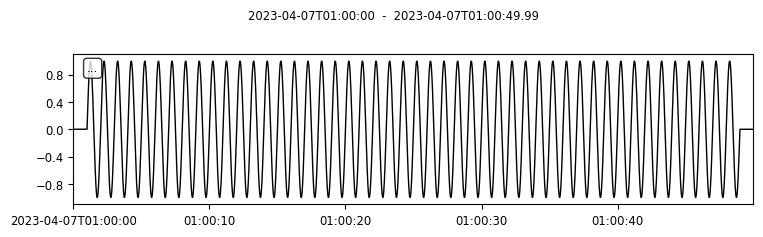

In [77]:
## chirp
# frequencies = np.linspace(fmin, fmax, NN)
# signal = chirp(t_axis, fmin, t_axis[-1], fmax, method="quadratic", phi=0)
# signal = np.sin(2*np.pi*frequencies*t_axis)


## mixing
# frequencies= 1 + 0.01 * np.sin(2*np.pi*0.1*t_axis)
# frequencies= 1 + 0.01 * chirp(t_axis, fmin, t_axis[-1], fmax, method="linear", phi=0)
# signal = np.sin(2*np.pi*frequencies*t_axis)


## monofrequent
frequencies = np.ones(NN)*f_dom
signal = np.sin(2*np.pi*frequencies*t_axis)


signal[:padding_n_samples], signal[-padding_n_samples:] = 0, 0

## convert to stream object
st = __to_stream(signal, sps, "2023-04-07 01:00")


st.plot();

In [109]:
config['n_windows'] = 4

tt, ff, a, b = __loop(config, st, method="hilbert_multitaper")

[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]


[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]


[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]
[ 0.99999718  0.999843    0.99621542  0.95212473]


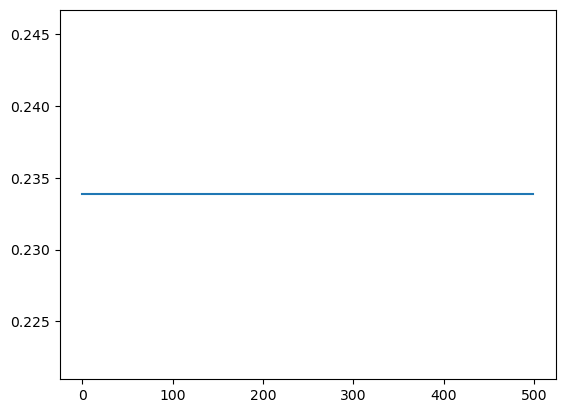

In [110]:
plt.plot(ff)

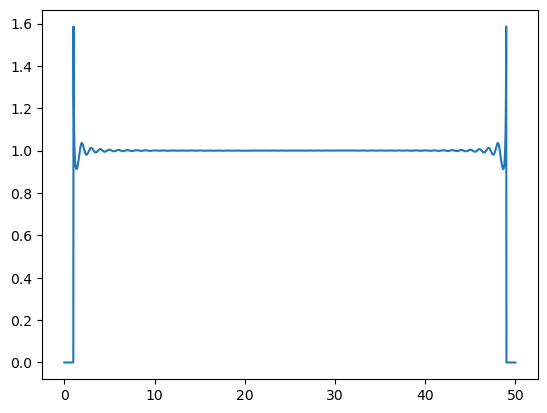

In [78]:
tt_hil, ff_hil = __hilbert_simple(st)

plt.plot(tt_hil, ff_hil)

(array([  6.10426077e-03,   1.83127823e-02,   3.05213039e-02, ...,
          4.99755830e+01,   4.99877915e+01,   5.00000000e+01]),
 0.99499450616530538,
 288.79726859637384,
 0.87171572141343745)

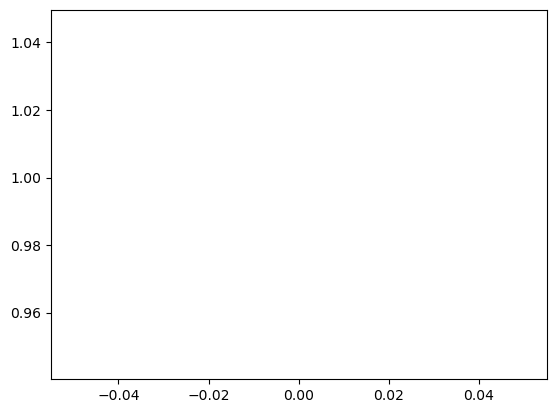

In [84]:
tt_mul, ff_mul, a, b = __multitaper(st[0].data, sps, n_windows=4, one_sided=True)

plt.plot(ff_mul)

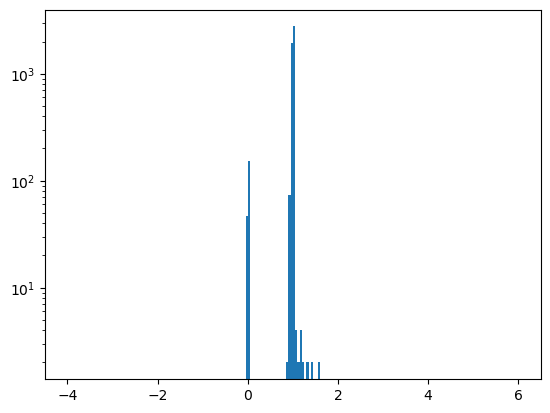

In [80]:

plt.hist(ff_hil, bins=200, log=True, range=(f_dom-5, f_dom+5));

## Test Loop

hilbert 10000

 interval: 2000.0s  |  sps: 10Hz  |  steps: 0.1s


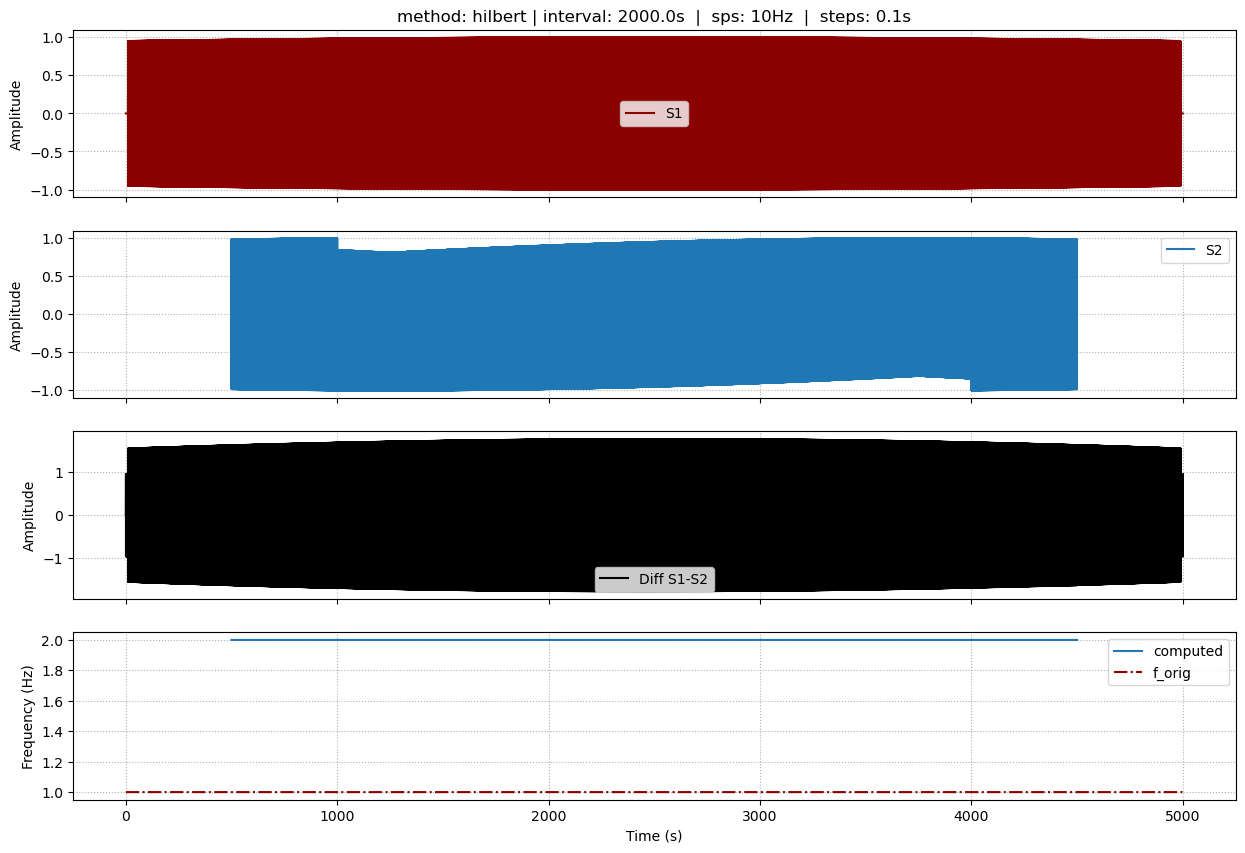

In [24]:
intervals = [10000]

# methods = ['hilbert', 'hilbert_multitaper', 'spectrogram_multitaper', 'multitaper']
methods = ['hilbert']

pairs = []
for interval in intervals:
    for method in methods:
        pairs.append([method, interval])
        

for args in tqdm(pairs):
    
    method, interval = args
    print(method, interval)
    
    config = {}

    config['n_windows'] = 10

    config['time_steps'] = 1/sps # seconds

    config['half_time_interval'] = interval/sps # seconds  [ it is +- this interval! ]

    config['method'] = method

    print(f"\n interval: {2*config['half_time_interval']}s  |  sps: {sps}Hz  |  steps: {config['time_steps']}s")

    ## ________________________________________________

    ## estimate insta. frequency
    try:
        tt, ff, hh, pp = __loop(config, st, method=config['method'])
    except Exception as e:
        print(e)
        print("estimate failed!")

    ## interpolate to match the original times
    ff_interp = np.interp(st[0].times(), tt, ff)
    signal_reconst_interp = np.sin(2*np.pi*ff_interp*st[0].times())
    
    signal_reconst = np.sin(2*np.pi*ff*tt)

    ## make figure
    fig = __plot(config);

    ## save figure
    fig.savefig(f"./figs/mono_{config['method']}_{interval}.png")

    ## store data
    df = DataFrame()
    df['times_orig'] = t_axis
    df['frequencies_orig'] = frequencies
    df['times'] = tt
    df['frequencies'] = ff
    df.to_pickle(f"./data/mono_{config['method']}_{interval}.pkl")


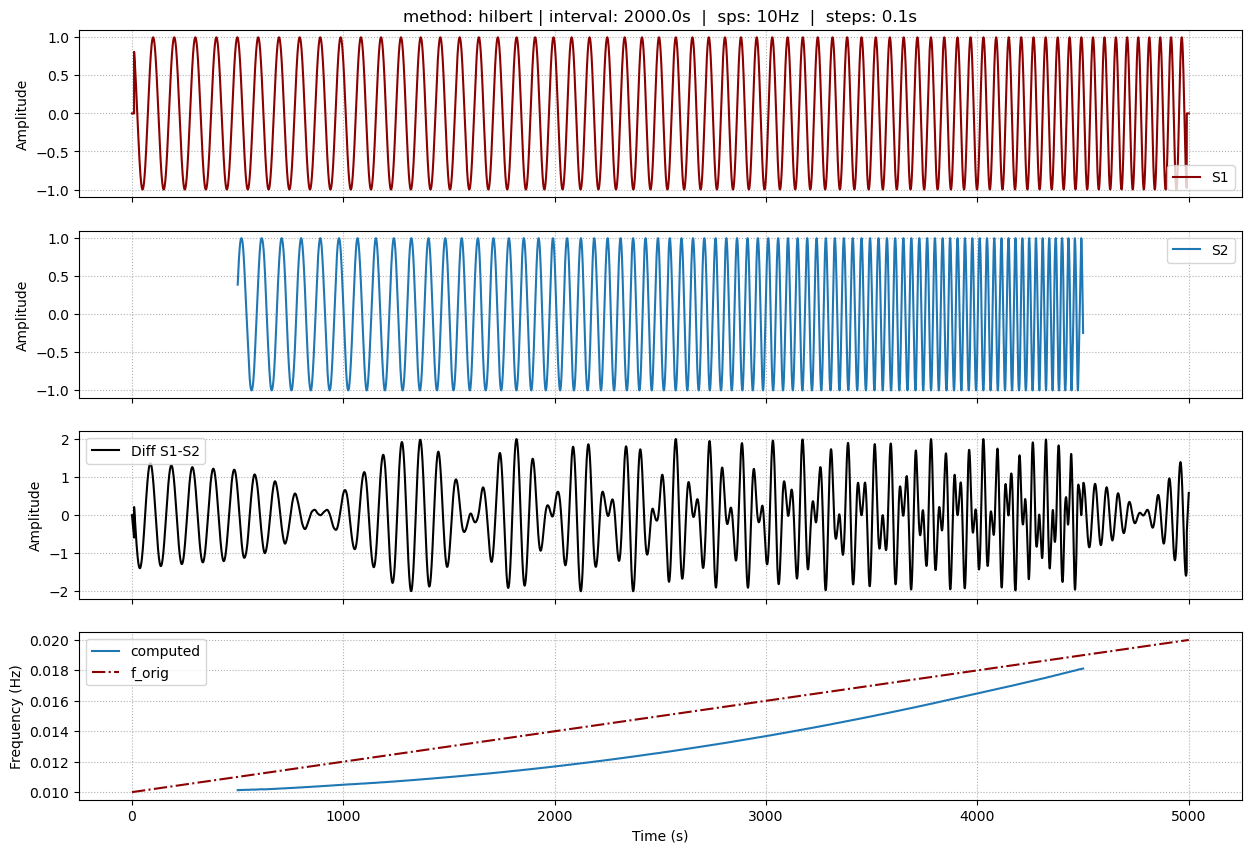

In [66]:
fig = __plot(config);